In [1]:
import torch
import numpy as np
import networkx as nx
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from datasets import load_dataset
from graph import process_dataset, centrality
from IPython.display import clear_output
from functools import partial
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

import sys

sys.path.append("../")

from hdc import hdv, bind, bundle, sbundle, hdvsc, hdvw, ItemMemory
from plots import bars, bars_simple

torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def encode_graphe(graph, vertices, dimensions):
    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdv(dimensions)

    Es = []

    for edge in graph.edges:
        Es.append(bind([vertices[edge[0]], vertices[edge[1]]]))

    return bundle(Es)


def encode_graphv(graph, vertices, dimensions):
    Vs = []

    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdv(dimensions)
        Vs.append(vertices[node])

    return bundle(Vs)


class GraphHD(BaseEstimator, TransformerMixin):
    def __init__(self, dimensions, encoder):
        self.dimensions = dimensions
        self.vertices = dict()
        self.encoder = encoder

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        vs = []
        for x in X:
            vs.append(self.encoder(x, self.vertices, self.dimensions))
        return vs

In [3]:
def encode_graphew(graph, vertices, base):
    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdvw(base, float(node))

    Es = []

    for edge in graph.edges:
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        Es.append(bind([v1, v2]))

    return bundle(Es)


def encode_graphvw(graph, vertices, base):
    Vs = []

    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdvw(base, float(node))
        Vs.append(vertices[node])

    return bundle(Vs)


class StochHD(BaseEstimator, TransformerMixin):
    def __init__(self, dimensions, encoder):
        self.dimensions = dimensions
        self.base = hdv(dimensions)
        self.encoder = encoder
        self.vertices = dict()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        vs = []
        for x in X:
            vs.append(self.encoder(x, self.vertices, self.base))
        return vs

In [4]:
def encode_graphvc(graph, vs):
    return bundle(list(map(lambda n: vs[round(float(n) * len(vs))], graph.nodes)))


class ConvHD(BaseEstimator, TransformerMixin):
    def __init__(self, vs, encoder):
        self.vs = vs
        self.encoder = encoder

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        vs = []
        for x in X:
            vs.append(self.encoder(x, self.vs))
        return vs

In [5]:
class BaseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rank, digits=5):
        self.rank = rank
        self.digits = digits

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        graphs = []
        for graph in X:
            gpr = self.rank(graph)
            nodes = dict()
            for key, value in gpr.items():
                nodes[key] = round(value, self.digits)
            H = nx.relabel_nodes(graph, nodes)
            graphs.append(H)
        return graphs


class BaseClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, step):
        self.memory = ItemMemory()
        self.step = step

    def fit(self, X, y):
        classes = {label: [] for label in set(y)}

        for i in range(len(X)):
            classes[y[i]].append(X[i])

        for key, value in classes.items():
            for i in range(0, len(value), self.step):
                H = bundle(value[i : i + self.step])
                self.memory.add_vector(key, H)

        return self

    # def fit(self, X, y):
    #     for i in range(len(X)):
    #         self.memory.add_vector(y[i], X[i])
    #     return self

    def predict(self, X):
        p = []

        for query in X:
            p.append(self.memory.cleanup(query)[0])

        return p

In [6]:
DATASET = load_dataset("graphs-datasets/MUTAG")["train"]
# DATASET = load_dataset("graphs-datasets/PROTEINS")["train"]

(graphs, labels) = process_dataset(DATASET)

# vs = hdvsc(10000, 10000, side=500, iter=4)

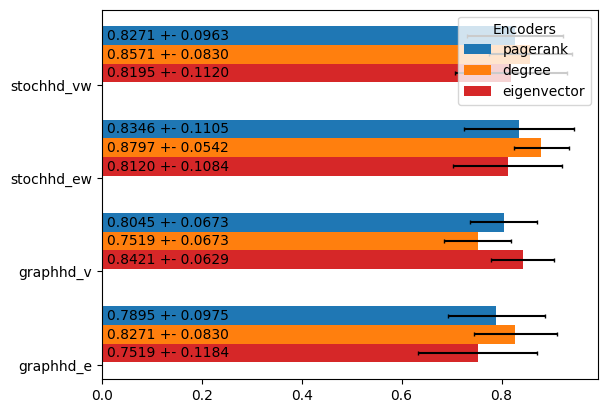

In [7]:
FOLDS, REPS = 3, 1
DIMENSIONS, ALPHA, STEP, DIGITS = 10000, 0.85, 200, 3


transformers = {
    "pagerank": partial(nx.pagerank, alpha=ALPHA),
    "degree": nx.degree_centrality,
    "eigenvector": partial(nx.eigenvector_centrality_numpy),
    "katz": partial(nx.katz_centrality_numpy),
    "betweenness": partial(nx.betweenness_centrality),
    "closeness": partial(nx.closeness_centrality),
    "laplacian": partial(nx.laplacian_centrality),
}


encoders = {
    "graphhd_e": GraphHD(DIMENSIONS, encode_graphe),
    "graphhd_v": GraphHD(DIMENSIONS, encode_graphv),
    "stochhd_ew": StochHD(DIMENSIONS, encode_graphew),
    "stochhd_vw": StochHD(DIMENSIONS, encode_graphvw),
}


def create_pipeline(encoder, transformer, graphs, labels):
    pipe = Pipeline(
        [
            ("transformer", BaseTransformer(transformer, digits=DIGITS)),
            ("encoder", encoder),
            ("classifier", BaseClassifier(step=STEP)),
        ]
    )
    scores = []
    for _ in range(REPS):
        scores.extend(
            cross_val_score(
                pipe,
                graphs,
                labels,
                cv=ShuffleSplit(n_splits=FOLDS),
                n_jobs=1,
                # verbose=4,
                error_score="raise",
            )
        )

    return scores


def main2():
    ascores = np.zeros((FOLDS * REPS, len(encoders), len(transformers)))
    for i, (_, encoder) in enumerate(encoders.items()):
        for j, (_, transformer) in enumerate(transformers.items()):
            scores = create_pipeline(encoder, transformer, graphs, labels)
            ascores[:, i, j] = scores

            bars(ascores, encoders.keys(), transformers.keys())
            clear_output(wait=True)
    # print(ascores)


def main():
    ascores, elabels = [], []
    for elabel, encoder in encoders.items():
        escores = []
        elabels.append(elabel)
        for _, trans in transformers.items():
            scores = create_pipeline(encoder, trans, graphs, labels)
            escores.append(scores)
            bars(np.array(ascores), transformers.keys(), encoders.keys())
            clear_output(wait=True)

        ascores.append(escores)
        # bars(np.array(ascores), transformers.keys(), elabels)
        # clear_output(wait=True)

    return np.array(ascores)


main2()

# scores = main()
# bars(scores, transformers.keys(), encoders.keys())

In [8]:
# print(scores)

NameError: name 'scores' is not defined

In [ ]:
def conf():
    print("=> conf")
    pipe = Pipeline(
        [
            ("graphhd", GraphHD(DIMENSIONS, encode_graphv)),
            ("classifier", BaseClassifier()),
        ]
    )
    y_pred = cross_val_predict(pipe, graphs, labels, cv=FOLDS, n_jobs=1)
    print(accuracy_score(labels, y_pred))
    print(balanced_accuracy_score(labels, y_pred, adjusted=True))
    print(confusion_matrix(labels, y_pred))